In [1]:
import random
import copy
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Dataset:
    def __init__(self,X,y,proportion=0.8,shuffle=True, mini_batch=0):
        """
        Dataset class provide tools to manage dataset

        :param X: ndarray, features, highly recommand ndarray
        :param y: ndarray, labels
        :param proportion: number between 0 and 1, the proportion of train dataset and test dataset
        :param shuffle: boolean,
        :param mini_batch mini batch size, 0 by default, in this case no mini batch size dataset will be generated
        """
        self.X = X
        self.y = y
        self.trainset = None
        self.testset = None
        self.validationset = None
        self.proportion = proportion
        self.shuffle = shuffle
        self.mini_batch = mini_batch
        self.allset = np.concatenate((X,y),axis=1)
        self.minisets = []

        if self.shuffle:
            # automatic distribution
            self.distribute()

    # @classmethod
    # def imageset(cls, path, proportion = 0.8, shuffle = None):
    #     pass

    def distribute(self):
        """
        This function will automatically distribute train and test dataset
        call this function to reshuffle all the dataset and also generate new train and test set
        """
        n = np.shape(self.X)[0]
        samples = np.concatenate((self.X,self.y),axis=1)
        random.shuffle(samples)
        # sample train and test dataset
        self.trainset = samples[0:round(n*self.proportion),:]
        self.testset = samples[round(n*self.proportion)+1:, :]

    def getX(self):
        return self.X

    def gety(self):
        return self.y

    def getminibatch(self):
        return self.mini_batch

    def gettrainset(self):
        """
        :return: return train dataset with respect of proportion
        """
        return Dataset(self.trainset[:, 0:self.X.shape[1]], self.trainset[:, self.X.shape[1]:], mini_batch=self.mini_batch)

    def gettestset(self):
        """
        :return: test dataset with respect of proportion
        """
        return Dataset(self.testset[:, 0:self.X.shape[1]], self.testset[:, self.X.shape[1]:])

    def getminiset(self):
        """
        get mini sets with mini batch size
        :return: Dataset array
        """
        spilit_list = np.arange(self.mini_batch, self.allset.shape[0], self.mini_batch)
        minisets = np.split(self.allset, spilit_list)
        for i in range(len(minisets)):
            self.minisets.append(Dataset(minisets[i][:, 0:self.X.shape[1]], minisets[i][:, self.X.shape[1]:],shuffle =False, mini_batch=self.mini_batch))
        return self.minisets


In [3]:
class NN:
    import numpy as np
    def __init__(self,dataset):
        """
        This class contains Activation function util class, Layer class for construct networks, it contains several extend classes like LinearLayer, Conv2D etc.

        Examples:

        layer_list = [NN.Layer('Linear',3,10,'sigmoid',BN=True), NN.Layer('Linear',10,100,'sigmoid',BN=True),
              NN.Layer('Linear',100,10,'sigmoid',BN=True),NN.Layer('Linear',10,3,'none') ]

        dataset = Dataset(X, y, mini_batch= 64)

        nn = NN(dataset)

        layer_list is a list has 4 layers all are Layer class. Note that here we don't use LinearLayer,
        to use LinearLayer, replace NN.Layer('Linear',3,10,'sigmoid',BN=True) as NN.LinearLayer(,3,10,'sigmoid',BN=True) or
        NN.LinearLayer(3,10,'sigmoid'), NN.BN()

        :param dataset: Dataset class
        """
        # self.input = input
        self.dataset = dataset
        self.layer_list = []

    def addlayers(self,layers):
        self.layer_list = layers

    def getlayers(self):
        return self.layer_list

    # activation functions
    class ActivationFunc:
        """
        ActivationFunc is an util class with different types of activation function.
        it can
        """
        @staticmethod
        def sigmoid(x):
            """
            Sigmoid function
            """
            return 1.0 / (1.0 + np.exp(-x))

        @staticmethod
        def ReLU(x):
            """
            :param x: ndarray,  
            :return:
            """
            return np.maximum(0, x)

        @staticmethod
        def LeakyReLU(x):
            return  np.where(x > 0, x, x * 0.01)

        @staticmethod
        def tanh(x):
            return np.tanh(x)

        @staticmethod
        def none(x):
            return x

    # Layer class
    class Layer:
        def __init__(self, type, input_dim, output_dim, activation, BN = False):
            """
            Define a layer contains activation function or other normalization.

            :param type: Layer type, choose 'Linear', 'Conv' etc
            :param input_dim: input dim or previous layer's output
            :param output_dim: output dim of this layer
            :param activation: activation function, it now support "sigmoid", "ReLU", "LeakyReLU", "tanh" and "none" for no activation function
            :param BN, batch normalization , Default False

            Examples:

            A linear layer with input dim = 3 and output dim = 10, following batch normalization and a sigmoid activation function
            NN.Layer('Linear',3,10,'sigmoid',BN=True)

            """
            self.type = type
            self.input_dim = input_dim
            self.output_dim = output_dim
            self.activation = activation
            self.BN = BN

        def getinputdim(self):
            return self.input_dim

        def getoutputdim(self):
            return self.output_dim

        def gettype(self):
            return self.type

        def getact(self, x):
            func_name = "NN.ActivationFunc."+self.activation
            func = eval(func_name)
            return func(x)

        def getactname(self):
            return self.activation

        def getBN(self):
            return self.BN

    class LinearLayer(Layer):
        """
        Define a linear layer

        As same as Layer except no need to clarify type
        """
        def __init__(self, input_dim, output_dim):
            self.type = "Linear"
            self.input_dim = input_dim
            self.output_dim = output_dim


    class Conv2DLayer(Layer):
        """
        Define a 2D convolutional layer_
        """
        def __init__(self, input_size, kernel_size, stride, padding):
            """
            initialize 2D conv layer

            :param input_size: Union[tuple, ndarray]  layer's input size
            :param kernel_size:  Union[tuple, ndarray] layer's kernel size
            :param stride: Int
            :param padding: Int
            """
            self.type = "Conv2D"
            self.input_size = input_size
            self.kernel_size = kernel_size
            self.stride = stride
            self.padding = padding

        def getimagesize(self):
            return self.image_size

        def getkernelsize(self):
            return self.kernel_size

        def getstride(self):
            return self.stride

        def getpadding(self):
            return self.padding

    class BN(Layer):
        def __init__(self):
            """
            Define a batch normalization layer
            """
            self.type = "BN"
            self.activation ="none"


In [4]:
class Optimizer:
    def __init__(self,nn,optimizer,batch_size=8,epoch=20000,lr=0.0001,decay_rate=0):
        """
        :param nn: input an NN class
        :param optimizer: optimizer as "GD", "SGD" etc
        :param batch_size: batch size for mini batch optimization
        :param epoch: epoch number
        :param lr: learning rate
        :param decay_rate: float, learning rate decay rate by default is 0
        """

        self.nn = nn
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.epoch = epoch
        self.lr = lr
        self.weight_list = None
        self.gradient_list = None
        self.loss_list = None
        self.passer_list = None
        self.decay_rate = decay_rate

    class LossFunc:
        @staticmethod
        def log_loss(y_true, y_pred, eps=1e-16):
            """
            Loss function we would like to optimize (minimize)
            We are using Logarithmic Loss
            http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss
            """
            y_pred = np.maximum(y_pred,eps)
            y_pred = np.minimum(y_pred,(1-eps))
            return -(np.sum(y_true * np.log(y_pred)) + np.sum((1-y_true)*np.log(1-y_pred)))/len(y_true)

        @staticmethod
        def quadra_loss(y_true, y_pred):
            return 1/y_true.shape[0] * 0.5*np.sum((y_pred-y_true)**2)

    class Node:
        def __init__(self, data: np.ndarray, type : str):
            """
            Node class, is the node of binary tree which has two child node: left and right.
            It can also be presented as weight. Every passer during the back propagation is saved as
            a node class contains data, type, back and cache for calculation

            :param data: ndarray, value given during forward propagation
            :param type: str, the type of node, it can be "weight", "data" or calculation like "@", "+" etc
            :param back: ndarray, value updated during back propagation
            :param cache: array_like stock forward propagation's detail and middle value for the convenient of back propagation
            """
            self.left = None
            self.right = None
            self.data = data
            self.type = type
            self.back = None
            self.cache = None

        def getleft(self):
            return self.left

        def getright(self):
            return self.right

        def gettype(self):
            return self.type

        def getdata(self):
            return  self.data

        def getback(self):
            return  self.back

    def getgradientlist(self):
        return self.gradient_list

    def getlosslist(self):
        return self.loss_list

    def getweightlist(self):
        return self.weight_list

    class WeightIni:
        """
        Provide weight initial functions. util class
        """
        @staticmethod
        def init_linear_weight(input_dim, output_dim):
            return np.random.uniform(-1, 1, (input_dim, output_dim))

        @staticmethod
        def init_BN_weight(dim):

            return np.ones((1, dim)), np.ones((1, dim))

        @staticmethod
        def init_conv2D_kernel(shape):
            """
            :param shape: Union[tuple, int, float] shape of kernel
            :return:
            """
            return np.random.random(shape)

        @staticmethod
        def initial_weight_list(layer_list):
            """
            @Staticmethod. Given layer list and return respected initiall weight list

            :param layer_list: list, layer list
            :return: list, list of weight in Node class
            """
            weight_list = []
            # initial weights in weight list by their type
            layer_num = len(layer_list)
            for i in range(layer_num):
                # linear weight operation
                if layer_list[i].gettype() == "Linear":
                    weight_list.append(Optimizer.Node(Optimizer.WeightIni.init_linear_weight(layer_list[i].getinputdim(), layer_list[i].getoutputdim()),"weight"))
                elif layer_list[i].gettype() == "BN":
                    dim = layer_list[i-1].getoutputdim()
                    gamma, beta = Optimizer.WeightIni.init_BN_weight(dim)
                    weight_list.append(Optimizer.Node(gamma,"weight"))
                    weight_list.append(Optimizer.Node(beta,"weight"))
                    layer_list[i].input_dim = dim
                    layer_list[i].output_dim = dim
                # kernel parse operation
                elif layer_list[i].gettype() == "Conv2D":
                    weight_list.append(Optimizer.Node(Optimizer.WeightIni.init_conv2D_kernel(layer_list[i].getkernelsize()),"weight"))
                else:
                    return  NameError
                # check if you need BN init
                if layer_list[i].getBN():
                    dim = layer_list[i].getoutputdim()
                    gamma, beta = Optimizer.WeightIni.init_BN_weight(dim)
                    weight_list.append(Optimizer.Node(gamma,"weight"))
                    weight_list.append(Optimizer.Node(beta,"weight"))

            return weight_list

    @staticmethod
    def forword(passer, weight_list, layer_list):
        layer_num = len(layer_list)
        passer_list = [Optimizer.Node(passer, "data")]
        # Every layer not necessarily has only one weight, like BN has 2 weights in a single layer
        weight_count = 0

        for i in range(layer_num):
            if layer_list[i].gettype() =='Linear':
                passer = passer@weight_list[weight_count].getdata()
                # append binary tree after inner product of weight and previous layer
                node = Optimizer.Node(passer,"@")
                node.left = passer_list[-1]
                node.right = weight_list[weight_count]
                passer_list.append(node)

                weight_count += 1

                if layer_list[i].getBN():
                    node_cache = [passer, np.var(passer,axis = 0), np.mean(passer, axis=0 )]

                    passer = (passer - np.mean(passer,axis=0))/np.sqrt(np.var(passer,axis=0))
                    node = Optimizer.Node(passer,"normalization")
                    node.cache = node_cache
                    node.left = passer_list[-1]
                    passer_list.append(node)

                    node = Optimizer.Node(passer,"*scalar")
                    node.left = passer_list[-1]
                    node.right = weight_list[weight_count]
                    passer_list.append(node)

                    passer = passer + weight_list[weight_count+1].getdata()
                    node = Optimizer.Node(passer,"+scalar")
                    node.left = passer_list[-1]
                    node.right = weight_list[weight_count+1]
                    passer_list.append(node)

                    weight_count += 2

                passer = layer_list[i].getact(passer)
                #append binary tree after activation function
                node = Optimizer.Node(passer,layer_list[i].getactname())
                node.left = passer_list[-1]
                passer_list.append(node)

            # elif layer_list[j].gettype() == "Conv2D":
            else: raise NameError

        return passer_list

    @staticmethod
    def backpropagation(node):
        epsilon = 1e-8
        if node.getleft() is not None:
            if node.gettype() == "@":
                node.getleft().back = node.getback()@node.getright().getdata().T
                node.getright().back = node.getleft().getdata().T@node.getback()
            elif node.gettype() == "sigmoid":
                node.getleft().back = np.multiply(node.getback(),np.multiply(NN.ActivationFunc.sigmoid(node.getback()),
                                                                             1-NN.ActivationFunc.sigmoid(node.getback())))
            elif node.gettype() == "ReLU":
                back = copy.deepcopy(node.getback())
                back[back<=0] = 0
                node.getleft().back = back
            elif node.gettype() == "LeakyReLU":
                back = copy.deepcopy(node.getback())
                back[back<0] = 0.01*back[back<0]
                node.getleft().back = back
            elif node.gettype() == "tanh":
                node.getleft().back = np.multiply((np.ones(node.getback().shape)-NN.ActivationFunc.tanh(node.getback())**2),
                                                  node.getback())
            elif node.gettype() == "+":
                node.getleft().back = node.getback()
                node.getright().back = node.getback()
            elif node.gettype() == "-":
                node.getleft().back = node.getback()
                node.getright().back = -node.getback()
            elif node.gettype() == "+scalar":
                node.getleft().back = node.getback()
                node.getright().back = np.sum(node.getback(),axis=0)
            elif node.gettype() == "*scalar":
                node.getleft().back = node.getright().getdata() * node.getback()
                node.getright().back = np.sum(node.getleft().getdata().T,axis=0)@node.getback()
            elif node.gettype() == "none":
                node.getleft().back = node.getback()
            elif node.gettype() == "normalization":
                # cache = [x,  sigma_beta^2, mu_beta]

                # dx = 1/N / std * (N * dx_norm -
                #       dx_norm.sum(axis=0) -
                #       x_norm * (dx_norm * x_norm).sum(axis=0))

                x = node.cache[0]
                sigma2 = node.cache[1]
                mu = node.cache[2]

                dl_dx_hat = node.getback()
                dl_dsigma2 = np.sum(dl_dx_hat,axis=0) * (x-mu) * -0.5*(sigma2+epsilon)**-3/2
                dl_dmu = np.sum(dl_dx_hat,axis=0) * -1/np.sqrt(sigma2+epsilon) + dl_dsigma2 * np.sum(-2*(x-mu),axis= 0)/x.shape[0]
                dl_dx = dl_dx_hat * 1/np.sqrt(sigma2+epsilon) + dl_dsigma2*2*(x-mu)/x.shape[0] + dl_dmu /x.shape[0]
                node.getleft().back = dl_dx

            Optimizer.backpropagation(node.getleft())
        else:
            return

    def lrdecay(self, iter):
        """
        Learning rate decay function. Given iteration, modify learning rate

        :param iter: int, iteration count
        """
        self.lr =  1 / (1 + self.decay_rate * iter) * self.lr

    def GD(self, root: Node, weight_list):
        """
        Gradient descent, do the back propagation and update weight list

        :param root: Node, the root of passer binary tree
        :param weight_list: list, weight list
        :return: list, updated weight list
        """
        Optimizer.backpropagation(root)
        gradient_list = []

        for node in weight_list:
            node.data = node.data - self.lr * node.back
            gradient_list.append(node.back)
        return weight_list, gradient_list

    def SGD(self, weight_list, passer_list):
        # we resume mini-batch equals 1 each time
        """
        Stochastic gradient descent. It takes weight list and passer list as inputs, it will
        :param weight_list:
        :param passer_list:
        :return:
        """
        def init_random_node(node, random_num_list, mini_weight_list):
            node.data = node.data[random_num_list,:]
            node.back = None
            if node.getright() is not None:
                mini_weight_list.append(node.getright())
            if node.getleft() is not None:
                init_random_node(node.getleft(), random_num_list, mini_weight_list)
            else: return

        # obs = observation number = output layer's dim 0
        num_obs = self.nn.dataset.gettrainset().getX().shape[0]
        mini_passer_list = copy.deepcopy(passer_list)
        root = mini_passer_list[-1]
        gradient_list = []

        # randomly pick observations from original obs
        random_num_list = np.random.randint(0, num_obs, num_obs)

        # initial random node
        mini_weight_list = []
        init_random_node(root, random_num_list, mini_weight_list)

        # back propagation
        root.back = 2 * (- self.nn.dataset.gettrainset().gety()[random_num_list] + root.getdata()[random_num_list])
        Optimizer.backpropagation(root)

        i = 0
        # update weight list
        for weight in weight_list:
            weight.data = weight.data - self.lr * mini_weight_list[-i-1].back
            gradient_list.append(mini_weight_list[-i-1].back)
            i = i + 1

        return weight_list, gradient_list

    def train(self):
        """
        train process, it will first initial weight, loss, gradient and passer list, then, optimize weights by given optimizer.
        In the end, calculate loss and step to the next epoch.

        It will finally stock all the weight, loss, gradient and passer during the training process
        """
        layer_list = self.nn.getlayers()

        # initial weight, loss and gradient list
        self.weight_list = [[] for i in range(self.epoch+1)]
        self.weight_list[0] = Optimizer.WeightIni.initial_weight_list(layer_list)
        self.loss_list = np.zeros(self.epoch)
        self.gradient_list = [[] for i in range(self.epoch)]
        self.passer_list = [[] for i in range(self.epoch)]

        # for GD and SGD, they use full dataset, so need only read X and y once
        if self.optimizer =="GD" or self.optimizer == "SGD":
            X = self.nn.dataset.gettrainset().getX()
            X = Optimizer.Node(X, "data")
            for i in range(self.epoch):
                # forward propagation
                self.passer_list[i] = Optimizer.forword(X.getdata(), self.weight_list[i],layer_list)
                root = self.passer_list[i][-1]

                # calculate loss by using: loss2 * (-self.nn.dataset.gettrainset().gety() + root.getdata())
                self.loss_list[i] = Optimizer.LossFunc.quadra_loss(self.nn.dataset.gettrainset().gety(),root.getdata())
                root.back = 2 * (-self.nn.dataset.gettrainset().gety() + root.getdata())
                # upgrade gradient by selected optimizer
                if self.optimizer =="GD":
                    self.weight_list[i+1], self.gradient_list[i] = Optimizer.GD(self, root, self.weight_list[i])

                elif self.optimizer =="SGD":
                    self.weight_list[i+1], self.gradient_list[i]  = Optimizer.SGD(self, self.weight_list[i], self.passer_list[i])

        # mini batch type gradient descent
        elif self.optimizer =="minibatchgd" or self.optimizer =="Adam":
            for i in range(self.epoch):
                # get mini batch
                minisets = self.nn.dataset.gettrainset().getminiset()
                epoch_weight_list = [copy.deepcopy(self.weight_list[i])]
                epoch_loss_list = np.zeros(len(minisets))

                # GD for every mini batch
                for j in range(len(minisets)):
                    X_bar = minisets[j]
                    self.passer_list[i].append(Optimizer.forword(X_bar.getX(), epoch_weight_list[j], layer_list))

                    root = self.passer_list[i][j][-1]

                    root.back = 2 * (-X_bar.gety() + root.getdata())
                    epoch_loss_list[j] = Optimizer.LossFunc.quadra_loss(X_bar.gety(),root.getdata())

                    weight, gradient = Optimizer.GD(self, root, epoch_weight_list[j])
                    epoch_weight_list.append(weight)

                self.weight_list[i+1]= epoch_weight_list[-1]
                self.gradient_list[i] = gradient

                self.loss_list[i] = sum(epoch_loss_list)/len(epoch_loss_list)

                # learnign rate decay

                self.lrdecay(i)
                # every epoch shuffle the dataset
                self.nn.dataset.distribute()



In [5]:
class Visual:
    def __init__(self, optim):
        self.optim = optim

    def plotloss(self):
        """
        :return: plot loss flow during the training
        """
        plt.style.use('seaborn-whitegrid')
        fig = plt.figure()
        ax = plt.axes()
        ax.plot(self.optim.loss_list, label = 'loss')
        ax.legend(loc='upper right')
        ax.set_ylabel('Loss during the training')

    def plotgradientnorm(self):
        plt.style.use('seaborn-whitegrid')
        fig, axs = plt.subplots(len(self.optim.getgradientlist()[0]))
        for i in range(len(self.optim.getgradientlist()[0])):
            gradient_norm_list = []
            for j in range(len(self.optim.getgradientlist())):
                gradient_norm_list.append(np.linalg.norm(self.optim.getgradientlist()[j][i]))
            axs[i].plot(gradient_norm_list, label = 'norm 2')
            axs[i].legend(loc='upper right')
            axs[i].set_ylabel('W' + str(i) +" norm")


In [6]:
# total observation number
n = 300
# x1, x2 are generated by two
x1 = np.random.uniform(0,1,n)
x2 = np.random.uniform(0,1,n)
const = np.ones(n)
eps = np.random.normal(0,.05,n)
b = 1.5
theta1 = 2
theta2 = 5
Theta = np.array([b, theta1, theta2])
y = np.array(b * const+ theta1 * x1 + theta2 * x2 + eps)
y=np.reshape(y,(-1,1))
X = np.array([const,x1,x2]).T

/tmp/ipykernel_65061/3125526518.py:24: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


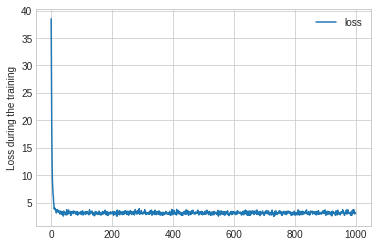

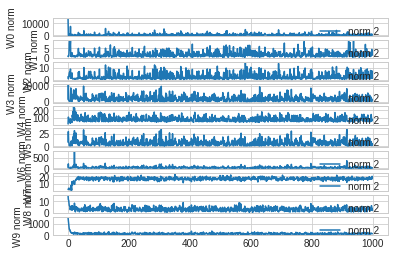

In [7]:
layer_list = [NN.Layer('Linear',3,10,'sigmoid',BN=True), NN.Layer('Linear',10,100,'sigmoid',BN=True),
              NN.Layer('Linear',100,10,'sigmoid',BN=True),NN.Layer('Linear',10,3,'none') ]
dataset = Dataset(X, y, mini_batch= 64)
nn = NN(dataset)
nn.addlayers(layer_list)
optim = Optimizer(nn,"minibatchgd",epoch = 1000, lr=1e-4, decay_rate=0.01)
optim.train()
visual = Visual(optim)
visual.plotloss()
visual.plotgradientnorm()

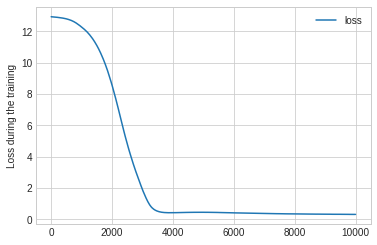

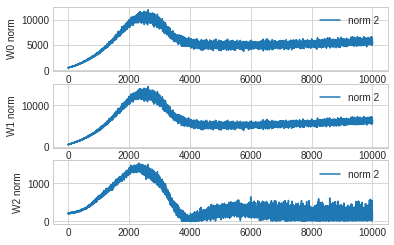

In [10]:
layer_list = [NN.Layer('Linear',3,100,'LeakyReLU'),NN.Layer('Linear',100,3,'LeakyReLU'),
              NN.Layer('Linear',3,1,'none')]
dataset = Dataset(X, y)
nn = NN(dataset)
nn.addlayers(layer_list)
optim = Optimizer(nn,"SGD",epoch = 10000, lr=1e-6)
optim.train()
visual = Visual(optim)
visual.plotloss()
visual.plotgradientnorm()